# VGG-16_functional

### VGGNet
* 2014년 ILSVRC 준우승 모델 / error_rate:10%
* Oxford 대학교 Visual Geometry Group의 Karen Simonyan과 Andrew Zisserman이 제안한 모델
* Large scale image recognition
* 3x3 Convolution filter
* Increasing depth

1. Architecture
    - Factorizing convolution → Implicit regularization
    - Pre-initialization (Like auxiliary classifier in GoogLeNet)
    - FC layer → Conv. layer
2. Dataset(augmentation)
    - Scale jittering
    - Multi-crop (GoogLeNet) and dense evalutation (OverFeat)

* 약 1537만개의 parameter

## Mount Google Drive

In [1]:
# Colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

## Import Library

In [2]:
# Data
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds

# Preprcessing

# Model
import tensorflow as tf
from tensorflow.keras import Sequential, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Visualizatoin
from tensorflow.keras.utils import plot_model
from PIL import Image
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Env
import os

## GPU Setting

In [3]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


## Hyper parameters

In [4]:
#Path
DATA_DIR='../data/'
SAVE_DIR='../model/VGGNet_subclassing/'
LOAD_DIR='../model/VGGNet_subclassing/'

#Hyper parameter
BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE=100
VERBOSE=1
PATIENCE=5
VALIDATION_SPLIT=0.2
EPOCHS=20

## Load data

In [5]:
(raw_train_ds, raw_val_ds, raw_test_ds), metadata = tfds.load(
    name='cifar10', split=['train[0:80%]', 'train[80%:]', 'test[0:100%]'], shuffle_files=True, with_info=True, as_supervised=True
)

In [6]:
train_len = raw_train_ds.__len__()
val_len = raw_val_ds.__len__()
test_len = raw_test_ds.__len__()
print(train_len, val_len, test_len, sep='\n')

tf.Tensor(40000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [7]:
raw_train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

class 확인

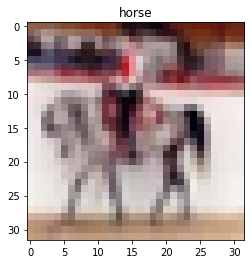

In [8]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(raw_train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [9]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

10


샘플 개수 확인

### PIL Image

In [10]:
# pil_image = Image.fromarray(X_train_raw[0])
# pil_image.show()

## Preprocessing

### Resizing

In [11]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(height=224, width=224),
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0)
])

In [12]:
result = resize_and_rescale(image)
result[0][0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.56078434, 0.37647063, 0.27450982], dtype=float32)>

In [13]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 1.1219707e-07 0.97647065


## Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(height=224, width=224),
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(factor=0.2)
])

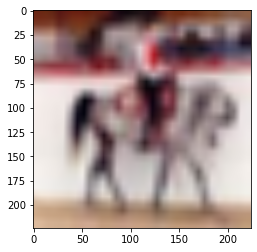

In [15]:
augmented_image = data_augmentation(result)
plt.imshow(augmented_image)

## Two options to use the Keras preprocessing layers

전처리 레이어를 사용할 수 있는 두 가지 옵션이 있다. 두 옵션에는 trade-off 가 있기 때문에 적절한 선택을 하는게 좋다.  
option 1: 전처리 레이어를 모델의 일부로 만들기 (모델에 전처리 레이어 추가)  
option 2: 데이터셋에 전처리 레이어 적용하기
  
해당 모델에서는 option 2를 적용하기로 했다. 모델의 정의하기전에 데이터셋에 전처리 레이어(resize_and_rescale/augmentation)를 적용해준다.  
* 리사이즈, 리스케일은 trainset, testset 모두 적용해주고 데이터 증강은 trainset에만 적용해준다.

In [16]:
aug_ds = raw_train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

In [17]:
aug_ds

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [19]:
train_ds = prepare(raw_train_ds)
val_ds = prepare(raw_val_ds)
test_ds = prepare(raw_test_ds)

In [20]:
image, label = next(iter(train_ds))
image.shape

TensorShape([64, 224, 224, 3])

In [21]:
image[0].shape

TensorShape([224, 224, 3])

## Model definition
### VGG-16

Functional API

In [27]:
def VGG_16():
    # inputs
    inputs = tf.keras.Input(image[0].shape)
    
    # Initialize convolution layer
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu)(inputs)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu)(conv_1)

    pool_1 = tf.keras.layers.MaxPool2D()(conv_2)

    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=activations.relu)(pool_1)
    conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=activations.relu)(conv_3)

    pool_2 = tf.keras.layers.MaxPool2D()(conv_4)

    conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=activations.relu)(pool_2)
    conv_6 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=activations.relu)(conv_5)
    conv_7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=activations.relu)(conv_6)

    pool_3 = tf.keras.layers.MaxPool2D()(conv_7)

    conv_8 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation=activations.relu)(pool_3)
    conv_9 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation=activations.relu)(conv_8)
    conv_10 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation=activations.relu)(conv_9)

    pool_4 = tf.keras.layers.MaxPool2D()(conv_10)

    conv_11 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation=activations.relu)(pool_4)
    conv_12 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation=activations.relu)(conv_11)
    conv_13 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation=activations.relu)(conv_12)

    pool_5 = tf.keras.layers.MaxPool2D()(conv_13)

    flatten = tf.keras.layers.Flatten()(pool_5)
    dense_1 = tf.keras.layers.Dense(units=1024, activation=activations.relu)(flatten)
    dense_2 = tf.keras.layers.Dense(units=128, activation=activations.relu)(dense_1)
    outputs = tf.keras.layers.Dense(units=10, activation=activations.softmax)(dense_2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)
    

### Model Summary

In [28]:
model = VGG_16()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 106, 106, 128)     147584    
                                                           

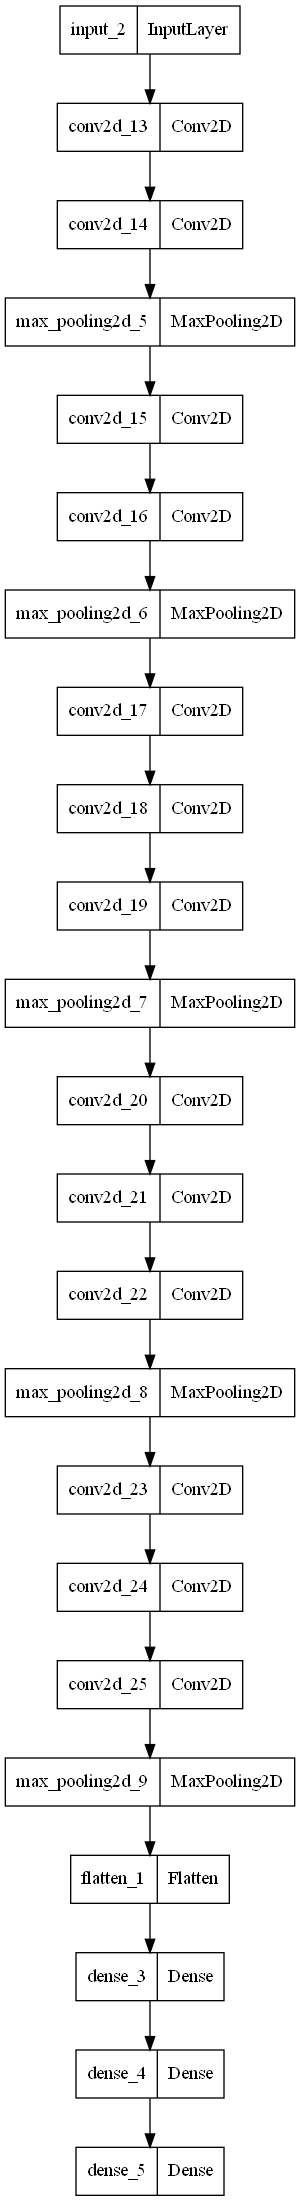

In [29]:
plot_model(model)

## Model Compile

In [30]:
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR+'cp.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

#compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [31]:
history = model.fit(train_ds, epochs=EPOCHS, callbacks=[es, mcp], validation_data=val_ds)

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.0993
Epoch 1: val_accuracy improved from -inf to 0.09870, saving model to ../model/VGGNet_subclassing\cp.01-2.30.hdf5
625/625 [==============================] - 278s 444ms/step - loss: 2.3032 - accuracy: 0.0993 - val_loss: 2.3030 - val_accuracy: 0.0987
Epoch 2/20
 71/625 [==>...........................] - ETA: 12:09 - loss: 2.3030 - accuracy: 0.0918

KeyboardInterrupt: 

## Test Model

In [ ]:
loaded_model = load_model(SAVE_DIR+'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

## Save Model

In [31]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ../model/AlexNet/trained-model.h5 


## Evaluation

### Loss / Accuracy

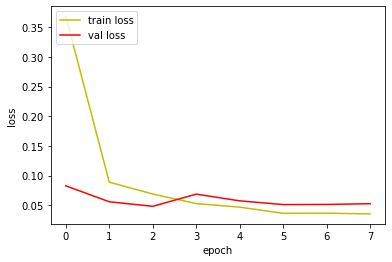

In [32]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
plt.show()

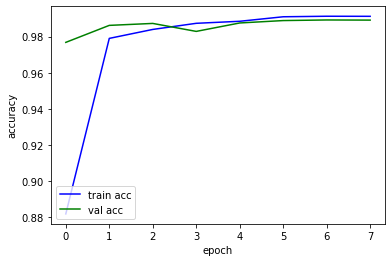

In [33]:
fig, acc_ax = plt.subplots()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')

acc_ax.legend(loc='lower left')

plt.show()

In [34]:
# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()


### Confusion matrix

In [35]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

313/313 [==============================] - 1s 4ms/step
[7 2 1 ... 4 5 6]


[[ 975    0    0    0    0    2    1    2    0    0]
 [   3 1127    0    2    1    0    0    2    0    0]
 [   1    2 1023    1    0    0    0    4    1    0]
 [   0    0    0 1001    0    7    0    1    1    0]
 [   0    0    0    0  978    0    0    0    0    4]
 [   0    0    0    2    0  888    1    1    0    0]
 [   2    3    0    0    3    2  948    0    0    0]
 [   0    3    1    0    0    0    0 1022    0    2]
 [   3    0    2    2    0    7    0    2  956    2]
 [   0    0    0    0    5    2    0    5    1  996]]


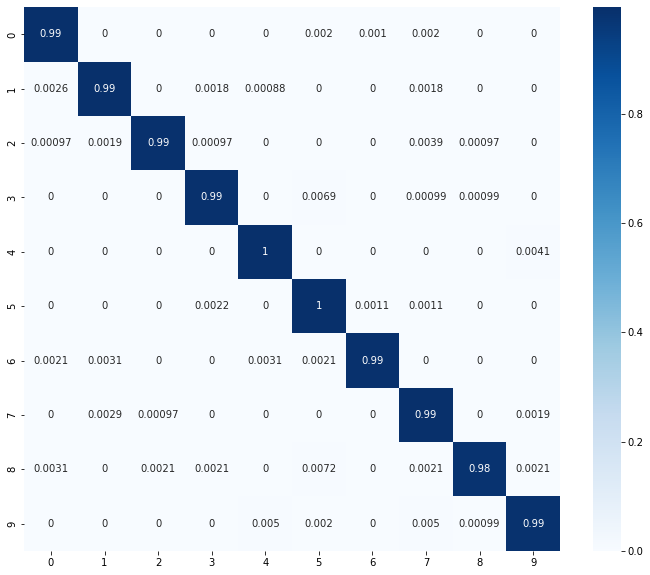

In [36]:
# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(10, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + 'output.png')

### precision, recall, f1 score

In [37]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score_s = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score_s)

accuracy_score:  0.9914
precision_score:  0.9913228270902772
recall_score:  0.9914020529366562
f1_score:  0.9913415338185736


## Load Model

In [38]:
model_name='trained-model.h5'
model_path=os.path.join(LOAD_DIR, model_name)
model=load_model(model_path)

## Predict

In [39]:
print(X_train.shape, X_train[0].shape, sep='\n')

(60000, 28, 28, 1)
(28, 28, 1)


In [40]:
def predict_mnist(tensor, model):
    sample=tf.reshape(tensor, [-1, 28, 28])
    result_prob=model.predict(sample, verbose=0)
    result=np.argmax(result_prob)
    print(result)

5 클래스에 대한 예측

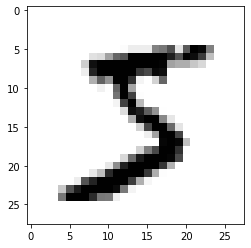

In [41]:
plt.imshow(X_train[0], cmap='gray_r', interpolation='nearest')
plt.show()

In [42]:
predict_mnist(X_train[0], model)

5


 0 클래스에 대한 예측

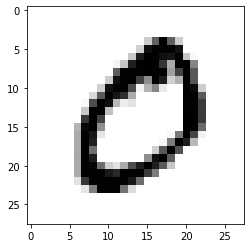

In [43]:
plt.imshow(X_train[1], cmap='gray_r', interpolation='nearest')
plt.show()

In [44]:
predict_mnist(X_train[1], model)

0
